## WEEK 4. Построение и оптимизация модели

В этом задании вам предстоит поучаствовать в соревновании на kaggle inclass Перейдите по ссылке на страницу соревнования: https://inclass.kaggle.com/c/telecom-clients-churn-prediction И приступайте! В соревновании вы будете работать с той же выборкой, что и ранее, поэтому воспользуйтесь результатами полученными на предыдущих неделях. Для успешного участия в соревновании необходимо преодолеть по качеству baseline решение.

На предыдущей недели лучшее решение дала модель Градиентного бустинга. Попробуем улучшить работу модели.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.utils import shuffle
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
train_data = pd.read_csv("orange_small_churn_train_data.csv")
test_data = pd.read_csv("orange_small_churn_test_data.csv")
data = pd.concat((train_data.iloc[:,:-1], test_data), axis=0).drop(columns=['ID'])
y = train_data.iloc[:,-1].fillna(-1.0)

In [13]:
#удалим переменные, у которых пропущенно более 70% данных:
NaN_num = (data.iloc[:, 0:190].isna().sum(axis = 0)/data.shape[0])
NaN_cat = (data.iloc[:, 190:].isna().sum(axis = 0)/data.shape[0])

NaN_num_del=[]
for i in range(NaN_num.shape[0]):
    if NaN_num[i]>=0.7: NaN_num_del.append(NaN_num.index[i])
NaN_cat_del=[]
for i in range(NaN_cat.shape[0]):
    if NaN_cat[i]>0.7: NaN_cat_del.append(NaN_cat.index[i])
        
X_num = data.iloc[:, 0:190].drop(columns=NaN_num_del)
X_cat = data.iloc[:, 190:].drop(columns=NaN_cat_del)

In [14]:
#заполняем пропуски у числовых фич средним значением
X_num = X_num.fillna(X_num.mean()) 

In [15]:
#удалим признаки, у которых более 50 различных категорий
unique = []
for j in X_cat.columns:
    if len(X_cat[j].dropna().unique())>50: unique.append(j)

X_cat = X_cat.drop(columns=unique)

In [16]:
#примением Onehotencoding
X_cat = pd.get_dummies(X_cat, dummy_na=True)    

In [17]:
#Объединим числовые и категориальные признаки
common_data = pd.concat((X_num, X_cat), axis=1)

X = common_data.iloc[:-10000,:]
X_kaggle = common_data.iloc[-10000:,:]

In [18]:
X.shape

(18299, 283)

In [19]:
# Отбор признаков на основе важности
GBclf = GradientBoostingClassifier(random_state=1)
GBclf.fit(X,y)
importance = GBclf.feature_importances_
importance = pd.DataFrame({"Feature": X.columns, "Importance": importance}) 
importance = importance.sort_values(by = importance.columns[1])

import_del=[]
for i in range(importance.shape[0]):
    if importance.Importance[i]==0: import_del.append(importance.Feature[i])
        
X_importance = X.drop(columns=import_del)
X_importance.shape

(18299, 106)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_importance, y, test_size=0.3, stratify=y, random_state=0)
cv_strategy = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
cross_val_score(GBclf, X_train, y_train, scoring = 'roc_auc', cv=cv_strategy).mean()

0.7201781295406047

### Подбор параметров

In [11]:
#Случайный поиск параметров по сетке
parameters_grid = {'n_estimators' : np.arange(70, 150, 10),
                  'learning_rate': np.arange(0.02, 0.12, 0.02),
                   'max_depth': np.arange(3, 10),
                   'max_features': np.arange(30, 100, 10),
                   'subsample': np.arange(0.2, 1.2, 0.2),
                   'random_state': np.arange(0, 42)
                  }
grid_cv = RandomizedSearchCV(GBclf, parameters_grid, scoring = 'roc_auc', cv = cv_strategy, n_iter=30, n_jobs=-1)
%time
grid_cv.fit(X_train, y_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_) 

Wall time: 0 ns
0.722962338795038
{'subsample': 0.8, 'random_state': 22, 'n_estimators': 80, 'max_features': 90, 'max_depth': 3, 'learning_rate': 0.04}


In [29]:
#подбор параметров на основе предыдущего отбора
parameters = {'n_estimators' : np.arange(110, 150, 10),
              'learning_rate': np.arange(0.04, 0.06, 0.01),
              'max_depth': np.arange(2, 5),
              'max_features': np.arange(40, 70, 10),
              'subsample': [1],
              'random_state': np.arange(11, 15)
              }
grid_cv = GridSearchCV(GBclf, parameters, scoring='roc_auc', n_jobs=-1, cv=cv_strategy)
%time
grid_cv.fit(X_train, y_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

Wall time: 0 ns
0.7250657745315443
{'learning_rate': 0.05, 'max_depth': 3, 'max_features': 40, 'n_estimators': 140, 'random_state': 11, 'subsample': 1}


In [21]:
model_params = {'n_estimators': 140,
                'max_depth': 3,
                'learning_rate': 0.05,
                'max_features': 40,
                'random_state': 11}
GBclf = GradientBoostingClassifier(**model_params)
cross_val_score(GBclf, X_train, y_train, scoring = 'roc_auc', cv=cv_strategy).mean()

0.7250664983293855

In [22]:
#Предсказание по тестовой выборке с kaggle
X_kaggle = X_kaggle.drop(columns=import_del)
GBclf.fit(X_importance, y)
GBclf_predictions = GBclf.predict(X_kaggle) 
GBclf_predictions_proba = GBclf.predict_proba(X_kaggle)

kaggle_result = pd.DataFrame(GBclf_predictions_proba[:,1], columns = ['result'])
kaggle_result.index.name = 'ID'

kaggle_result.to_csv('kaggle.csv', header=['result'], sep=',')

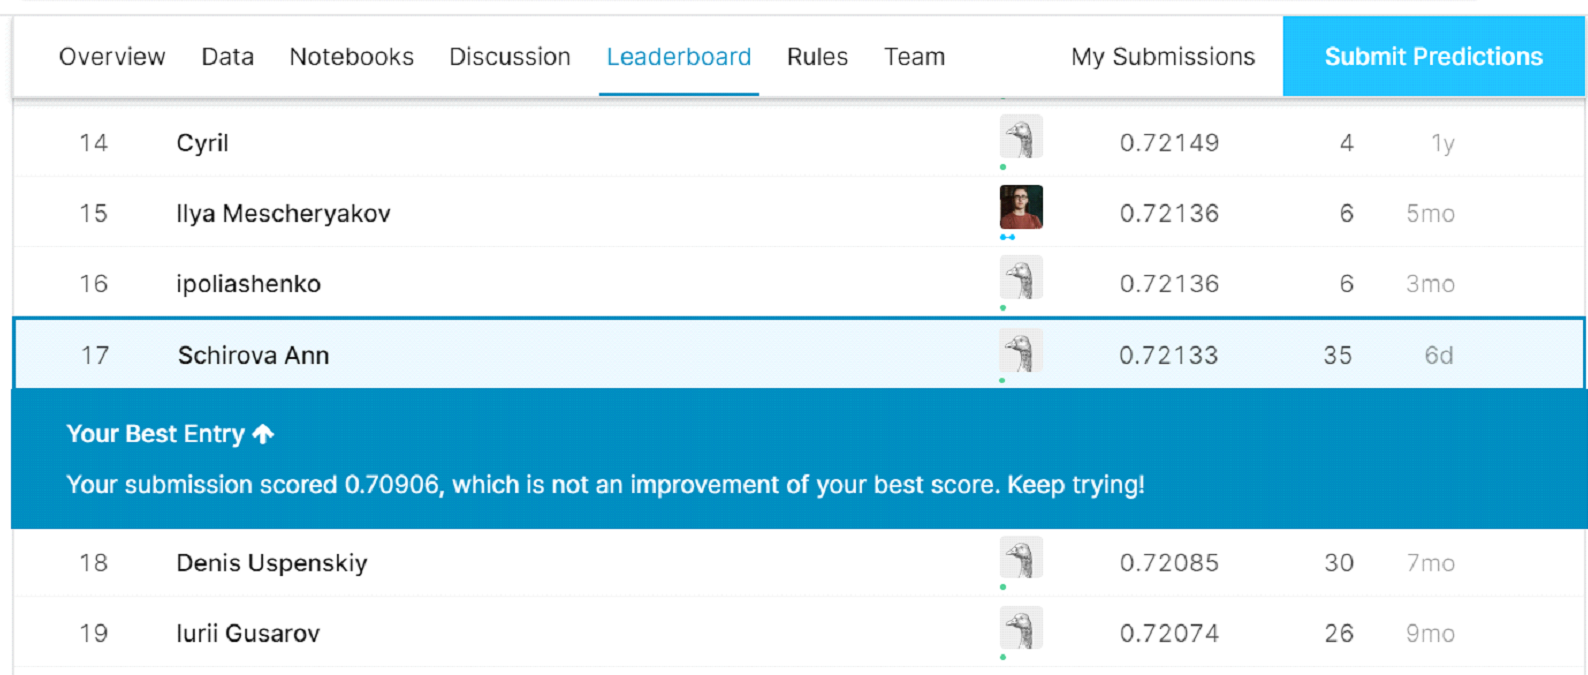

In [23]:
from IPython.display import Image
with open("./kaggle_result.png",'rb') as f:
    display(Image(data=f.read(), format='png'))

### Результат: на момент участия в соревновании качество построенной модели выше, чем baseline на kaggle.